In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from utils import optimal_interp_points, interp_matrix

from epsr import EPSR
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt

# define the cost function in XXZ model

In [16]:
num_q = 4 # N # IMPORTANT
layer = 2 # Define the number of layers in the quantum circuit

In [17]:
Delta = 0.5 # IMPORTANT
List_1 = []
op = ""
op = "X"
for k in range(num_q-2):
    op += "I"
op += "X"
List_1.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "XX"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)
List_1.reverse()
H1 = SparsePauliOp(List_1, np.ones(num_q))

List_2 = []
op = "Y"
for k in range(num_q-2):
    op += "I"
op += "Y"
List_2.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "YY"
    for k in range(i+1,num_q-1):
        op += "I"
    List_2.append(op)
List_2.reverse()
H2 = SparsePauliOp(List_2, np.ones(num_q))

H_first = SparsePauliOp.sum([H1,H2])

List_3 = []
op = "Z"
for k in range(num_q-2):
    op += "I"
op += "Z"
List_3.append(op)  
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_3.append(op)

List_3.reverse()    
H_second = SparsePauliOp(List_3, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H_first,H_second])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

# # Print with detailed descriptions
# print(f"Number of qubits (num_q): {num_q}")
# print(f"Delta value: {Delta}")
# print("List_1 (Pauli terms for XX interactions):")
# print(List_1)
# print("List_2 (Pauli terms for YY interactions):")
# print(List_2)
# print("List_3 (Pauli terms for ZZ interactions):")
# print(List_3)
# print(H.size)
# print(H)

In [18]:
# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")

Ground state is unique.
Ground state energy: -6.744562646538028
Eigenvalues: [-6.74456265e+00 -4.00000000e+00 -4.00000000e+00 -2.00000000e+00
 -3.94820641e-31 -1.27376008e-31 -1.18119571e-47  0.00000000e+00
  1.42519202e-33  9.02056208e-17  1.72746915e-16  2.00000000e+00
  2.00000000e+00  4.00000000e+00  4.00000000e+00  4.74456265e+00]


In [19]:
"""Circuit construction"""
# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

# qc = circuit_QAOA_XXZ(weights)
# # print(qc)
# qc.draw("mpl")


In [20]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0
    estimate_2 = 0
    estimate_3 = 0

    ########################### XX
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_1 += 1
            else:
                estimate_1 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_1 += 1
        else:
            estimate_1 += -1

    estimate_1 = estimate_1/SHOTS

    ########################### YY
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.sdg(i)
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_2 += 1
            else:
                estimate_2 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_2 += 1
        else:
            estimate_2 += -1
            
    estimate_2 = estimate_2/SHOTS

    ########################### ZZ
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_3 += 1
            else:
                estimate_3 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_3 += 1
        else:
            estimate_3 += -1
            
    estimate_3 = estimate_3/SHOTS

    
    estimate = estimate_1 + estimate_2 + Delta*estimate_3

    return estimate


def expectation_loss(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2




# set omegas for each coordinate j

In [21]:
# Construct weights_dict
weights_dict = {}

d=1

for j in range(num_p):

    if j % 2 == 0:  # Odd layers with RZZ gates
        # omegas = [1,2]
        # omegas = [1]
        omegas = [2]
        # omegas = [1, 2]
        # omegas = [1, 2]
        r = len(omegas)
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas,
            'r': r,
            'nodes_scheme':'numerical_optimal', # 'random', 'equidistant', 'numerical_optimal'
            'shot_scheme':'weighted', # 'weighted', 'uniform'
            # 'interp_nodes': interp_nodes,
        }

    elif j % 2 == 1:  # Even layers with RYY+RXX gates
        # omegas = [1,2,3,4]
        # omegas = [1, 2]
        omegas = [2, 4]
        # omegas = [1, 2, 3, 4]
        r = len(omegas)
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas,
            'r': r,
            'nodes_scheme':'numerical_optimal', # 'random', 'equidistant', 'numerical_optimal'
            'shot_scheme':'weighted', # 'weighted', 'uniform'
            # 'interp_nodes': interp_nodes,
        }
    
    # if j == num_p - 1:
    #     omegas = [1,2,4]
    #     r = len(omegas)
    #     # interp_nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
    #     weights_dict[f'weights_{j}'] = {
    #         'omegas': omegas,
    #         'r': r,
    #         'nodes_scheme':'numerical_optimal', # 'random', 'equidistant', 'numerical_optimal'
    #         'shot_scheme':'weighted', # 'weighted', 'uniform'
    #         # 'interp_nodes': interp_nodes,
    #     }

# if num_q == 7:
#     weights_dict[f'weights_0']['omegas'] = [1,2,3]
#     weights_dict[f'weights_1']['omegas'] = [1,2,3,4,5,6]
#     weights_dict[f'weights_2']['omegas'] = [1,2,3]
#     weights_dict[f'weights_3']['omegas'] = [1,2,3,4,5,6]
#     weights_dict[f'weights_4']['omegas'] = [1,2]
#     weights_dict[f'weights_5']['omegas'] = [1,2,3,4]
#     weights_dict[f'weights_6']['omegas'] = [1,2]
#     weights_dict[f'weights_7']['omegas'] = [1,2,4]



from epsr_utils import numerical_optimal_nodes
from epsr import EPSR

# load nodes for each parameter
for j in range(num_p):

    omegas = weights_dict[f'weights_{j}']['omegas']
    r = weights_dict[f'weights_{j}']['r']
    nodes_scheme = weights_dict[f'weights_{j}']['nodes_scheme']
    shot_scheme = weights_dict[f'weights_{j}']['shot_scheme']

    if nodes_scheme == 'random':
        nodes = np.random.uniform(0, np.pi, r)
    elif nodes_scheme == 'equidistant':
        # If omega is an equidistant multiple of 2, then it needs to be multiplied by 0.5.
        nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)]) # *0.5
    elif nodes_scheme == 'numerical_optimal':
        nodes, _ = numerical_optimal_nodes(omegas, shot_scheme)
    else:
        raise ValueError("Invalid nodes_scheme. Please provide 'random', 'equidistant', or 'numerical_optimal'.")
    
    weights_dict[f'weights_{j}']['nodes'] = nodes

    d = 1
    b = EPSR(nodes, np.array(omegas), d)
    weights_dict[f'weights_{j}']['b'] = b

    if shot_scheme == 'weighted':
        total_var = np.sum(np.abs(b))**2
    elif shot_scheme == 'uniform':
        total_var = r * np.sum(np.abs(b)**2)
    weights_dict[f'weights_{j}']['total_var'] = total_var


# Print example results
print(len(weights_dict))
for i in range(len(weights_dict)):
    print(weights_dict[f'weights_{i}'])


8
{'omegas': [2], 'r': 1, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes': array([0.78539816]), 'b': array([2.]), 'total_var': 4.0}
{'omegas': [2, 4], 'r': 2, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes': array([0.39269897, 1.17809732]), 'b': array([ 3.41421388, -0.58578612]), 'total_var': 16.000000000002714}
{'omegas': [2], 'r': 1, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes': array([0.78539816]), 'b': array([2.]), 'total_var': 4.000000000000002}
{'omegas': [2, 4], 'r': 2, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes': array([1.17809739, 2.74889355]), 'b': array([-0.58578659, -3.41421341]), 'total_var': 16.00000000000086}
{'omegas': [2], 'r': 1, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes': array([0.78539814]), 'b': array([2.]), 'total_var': 4.000000000000011}
{'omegas': [2, 4], 'r': 2, 'nodes_scheme': 'numerical_optimal', 'shot_scheme': 'weighted', 'nodes

In [22]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-2.40157312 -2.85027039  1.83284555]

 index to check =  1
omegas =  [2, 4]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-1.52670871 -3.71679522  0.34580391 -0.00907464  0.62622187]

 index to check =  2
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 1.02958176 -0.17265936  0.74804246]

 index to check =  3
omegas =  [2, 4]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 0.1809672  -0.44666912 -0.35848673 -1.46455453  0.58436776]

 index to check =  4
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [0.46186522 0.42095023 0.50365537]

 index to check =  5
omegas =  [2, 4]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [ 0.16503654 -1.01564818  0.29093216 -0.33579068  0.04028529]

 index to check =  6
omegas =  [2]
Consistent results: 50/50
【All Passed】
Estimated coefficie

In [23]:
initial_weights = np.zeros(num_p) #np.ones(num_p)
# initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
print(f"Ground state energy: {ground_e}")

Ground state energy: -6.744562646538028


In [24]:
# # RCD Optimization
# from rcd import rcd

# num_iter = 15000
# N_total=5000
# # Run RCD
# final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, expected_every_rcd, fid_every_rcd = rcd(
#     estimate_loss,
#     expectation_loss,
#     fidelity,
#     N_total,
#     weights_dict,
#     initial_weights,
#     num_iter,
#     cyclic_mode=False,
#     learning_rate=0.01,
#     decay_step=10,
#     decay_rate=-1,
#     decay_threshold=1e-4,
#     exact_mode=False,
#     plot_flag=True,
# )


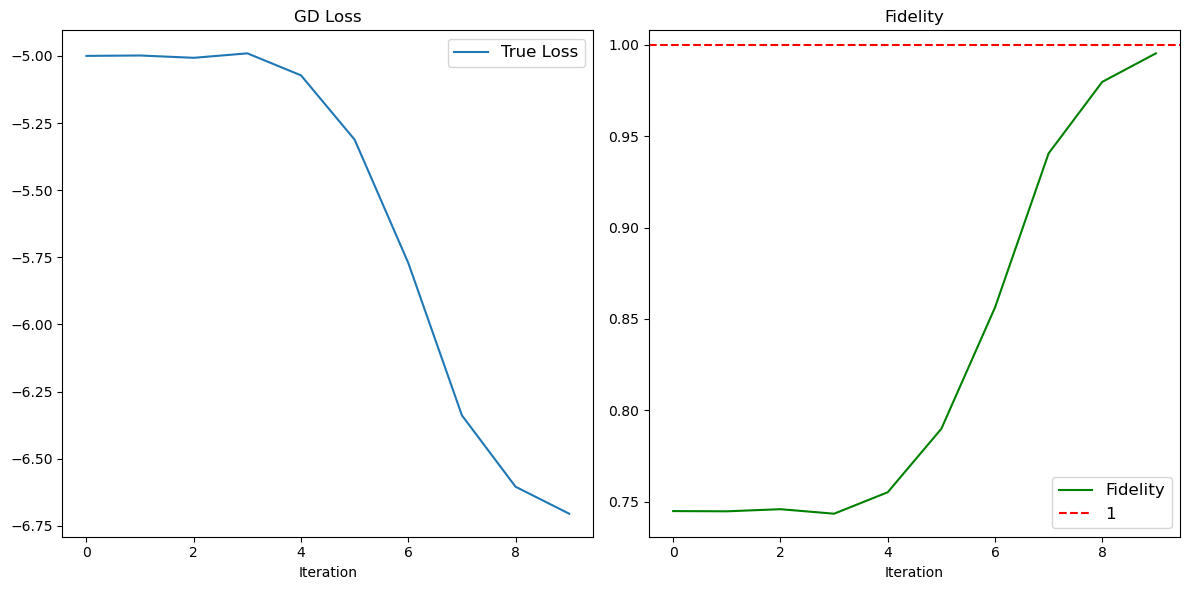

[GD] Iter: 8, Best loss: -6.7051, Cur. loss: -6.7051, Best Fid.: 0.9953, Cur. Fid.: 0.9953:   3%|▎         | 8/300 [00:13<08:06,  1.66s/it]


In [26]:
# Gradient Descent Optimization
from gd import gd

num_iter = 300
N_total=1000
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, expected_every_gd, fid_every_gd  = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    N_total,
    weights_dict, 
    initial_weights, 
    num_iter,
    # nodes_scheme='equidistant', # 'random', 'equidistant', 'numerical_optimal'
    # shot_scheme='weighted', # 'weighted', 'uniform'
    learning_rate=0.03, # VERY IMPORTANT
    exact_mode=False,
    plot_flag=True,
)


In [ ]:
expected_every_gd_1=expected_every_gd

normalized_expectation_1 = [val / ground_e for val in expected_every_gd_1]
# normalized_best_expectation = [val / ground_e for val in best_expected_record_value_gd]
normalized_expectation_1

[0.7413379135215675,
 0.7409677427009489,
 0.7413442759099171,
 0.741517064675965,
 0.7421935712982526,
 0.7422022318819312,
 0.7571723754123103,
 0.7858557791840713,
 0.8434511449606111,
 0.9242613216245836,
 0.971780646218068,
 0.9939121695398342]

In [ ]:
expected_every_gd_2=expected_every_gd

normalized_expectation_2 = [val / ground_e for val in expected_every_gd_2]
# normalized_best_expectation = [val / ground_e for val in best_expected_record_value_gd]
normalized_expectation_2


[0.7413379135215675,
 0.7409677427009489,
 0.7413442759099171,
 0.741517064675965,
 0.7421935712982526,
 0.7422022318819312,
 0.7571723754123103,
 0.7858557791840713,
 0.8434511449606111,
 0.9242613216245836,
 0.971780646218068,
 0.9939121695398342]

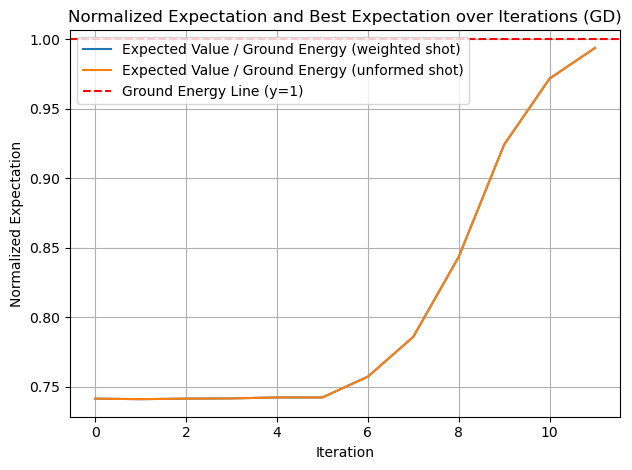

In [ ]:

plt.figure()
plt.plot(normalized_expectation_1, label='Expected Value / Ground Energy (weighted shot)')
plt.plot(normalized_expectation_2, label='Expected Value / Ground Energy (unformed shot)')
plt.axhline(y=1.0, color='red', linestyle='--', label='Ground Energy Line (y=1)')
plt.xlabel("Iteration")
plt.ylabel("Normalized Expectation")
plt.title("Normalized Expectation and Best Expectation over Iterations (GD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
